# Plot normalization factor

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

from corrpacmap import CorrelationPacMap
from llcmap import PacificMap
from matern import MaternField
from pych import get_cmap_rgb

In [2]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [3]:
plt.style.use('./correlation.mplstyle')

In [4]:
fs = 20
plt.rcParams.update({'axes.titlesize': 24,
                     'axes.labelsize': fs,
                     'font.size' : fs,
                     'legend.fontsize': fs,
                     'xtick.labelsize': fs,
                     'ytick.labelsize': fs,
                    })


In [59]:
horizontal_factor = 1
n_applications = 1
log10tol = -3
dslist = []
for n_range in [5, 10, 15, 20]:
    cc = CorrelationPacMap(n_range=n_range,
                           log10tol=log10tol,
                           n_applications=n_applications,
                           persist=False,
                           drop_coords=False,
                           select_outer_subregion=False)
    tmp = cc.open_dataset()
    mf = MaternField(tmp['maskC'], n_range=n_range, horizontal_factor=horizontal_factor, n_applications=n_applications)
    xds = tmp['smooth3Dnorm001'].to_dataset().expand_dims({'n_range':[n_range]})
    xds['ideal_variance'] = xr.DataArray([mf.ideal_variance], coords=xds.n_range.coords, dims=xds.n_range.dims)
    dslist.append(xds)
    
ds = xr.concat(dslist, dim='n_range')

In [60]:
ds.nbytes / 1e9

0.052978864

In [61]:
ds.load();

In [62]:
ds['ideal_norm'] = 1/np.sqrt(ds['ideal_variance'])
ds['ideal_std'] = np.sqrt(ds['ideal_variance'])
ds['smooth3Dstd001'] = xr.where(ds.maskC, 1/ds['smooth3Dnorm001'], 0.)
ds['smooth3Dvar001'] = ds['smooth3Dstd001']**2

In [63]:
mapper = PacificMap(ds)

In [64]:
k= 0  # 25 # 0
iy= 180  #165 # 180
#k=25
#iy=165

### Showing the map as the actual value 1/sigma

In [65]:
def make_normplot(fldname, idname, normalize=False, cmap='Blues_r',
                  vmin=0, vmax=1):
    
    fig = plt.figure(figsize=(24, 12), constrained_layout=True)
    
    projection = ccrs.Robinson(central_longitude=-120)
    xrange = [-180, -60]
    
    cc = get_cmap_rgb(plt.get_cmap(cmap))
    if '_r' in cmap:
        cc[-1] = [1,1,1,0]
    else:
        cc[0] = [1,1,1,0]
    cmap1 = plt.get_cmap(cmap).from_list('cmap', cc, N=10)
    cmap2 = cmap1.copy()
    cmap2.set_bad([.8]*3)
    mkw = {'vmin':vmin, 'vmax':vmax, 'cmap':cmap1, 'show_cbar': False}
    pkw = {'vmin':vmin, 'vmax':vmax, 'cmap':cmap2}
    
    nrows = 2
    ncols = len(ds.n_range.values)
    xds = ds.sel(ix=slice(40,None))
    axstop = []
    axsbot = []
    
    # This doesn't work for normalized case ... and is kinda ugly
    #cmaplist = ['Greens', 'Oranges', 'Blues', 'Reds']
    for i, n_range in enumerate(ds.n_range.values):
        
        
        ideal = float(ds[idname].sel(n_range=n_range))
        if not normalize:
            mkw['vmax'] = ideal
            pkw['vmax'] = ideal
        
        # Lat / Lon
        ax0 = fig.add_subplot(nrows, ncols, i+1, projection=projection)
        xda = ds[fldname].sel(n_range=n_range)
        xda = xda / ideal if normalize else xda
        p, gl = mapper(xda.sel(k=k), ax=ax0, **mkw)
        setattr(gl,'right_labels', False)
        ax0.spines['bottom'].set_visible(False)
        ax0.spines['right'].set_visible(False)
        axstop.append(ax0)
        
        # Z / Lon
        ax1 = fig.add_subplot(nrows, ncols, i+ncols+1)
        xda = xds[fldname].sel(n_range=n_range)
        xda = xda / ideal if normalize else xda
        pcorr = ax1.pcolormesh(xds.XC.sel(iy=iy), -xds.Z,
                               xda.where(xds.maskC).sel(iy=iy),
                               **pkw)
        ax1.invert_yaxis()
        ifc = ax1.get_subplotspec().is_first_col()
        ylabel = 'Depth (km)' if ifc else ''
        yticklabels = np.arange(6) if ifc else []
        xticklabels = [r"%d$^\circ$W" % lon for lon in np.arange(180, 50, -30)]
        ax1.set(xlim=xrange,
               xticks=np.arange(-180,-50, 30),
               xticklabels=xticklabels,
               ylabel=ylabel,
               yticklabels=yticklabels,
              )
        if not normalize:
            plt.colorbar(pcorr,
                         ax=ax1,
                         orientation='horizontal',
                         aspect=10)
        axsbot.append(ax1)
        
        # expected
        if 'norm' in fldname:
            #prefix = '1/\hat{\sigma}'
            ideal = 1/ideal
            
        #elif 'std' in fldname:
        #    
        #    prefix = '\hat{\sigma}'
            
        prefix = '\hat{\sigma}'
        
        if np.log10(ideal)>=-2 and np.log10(ideal)<2:
            mystr = r"$%s = %.2f$" % (prefix,ideal)
        else:
            exp = int(np.round(np.log10(ideal)))
            yo = ideal / 10**exp
            mystr =    r"$%s = %.1f \cdot 10^{%d}$" % (prefix,yo,exp)
        myrho = r"$\hat{\rho} = %d$" % int(xda.n_range)
        ax1.text(-95, 5500,myrho+"\n"+mystr,ha='center')
        
    if normalize:
        if 'std' in fldname:
            txt = 'Ratio of sample standard deviation to isotropic, stationary case'
            
        elif 'norm' in fldname:
            txt = 'Ratio of isotropic, stationary standard deviation to sample estimate'
            
        extend = 'max' if xda.max() > vmax else None
        if xda.min() < vmin and extend == 'max':
            extend='both'
        elif xda.min() < vmin:
            extend = 'min'
        fig.colorbar(pcorr,
                     ax=axsbot,
                     extend=extend,
                     orientation='horizontal',
                     aspect=30,
                     label=txt)

In [66]:
# Hard to interpret with raw values
#make_normplot('smooth3Dnorm001', 'ideal_norm')

/tmp/ipykernel_60573/3697730900.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set(xlim=xrange,
/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


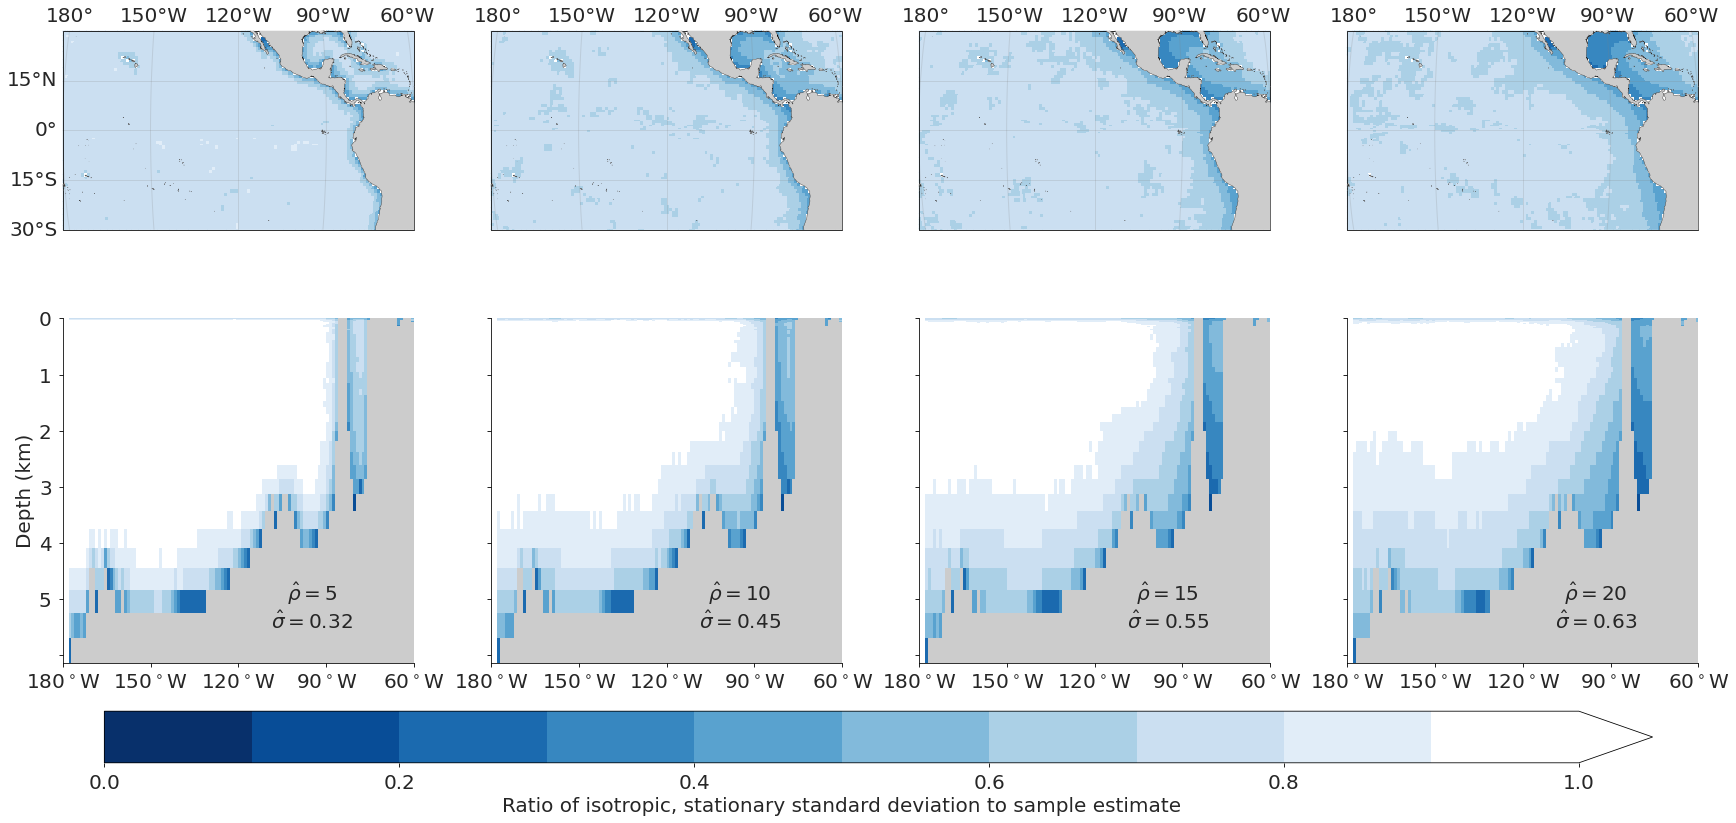

In [67]:
make_normplot('smooth3Dnorm001', 'ideal_norm', normalize=True)
plt.savefig(f"{fig_dir}/normalization_factor_{n_applications:02d}apps.jpg", dpi=300, bbox_inches='tight')

In [68]:
ratio = ds.smooth3Dnorm001 / ds.ideal_norm
ratio = ratio.where(ds.maskC)
print(ratio.min(['ix','iy','k']))
print(ratio.max(['ix','iy','k']))

<xarray.DataArray (n_range: 4)>
array([0.11960453, 0.07071658, 0.05753844, 0.05007   ])
Coordinates:
  * n_range  (n_range) int64 5 10 15 20
<xarray.DataArray (n_range: 4)>
array([1.12059179, 1.1188458 , 1.10374559, 1.10477463])
Coordinates:
  * n_range  (n_range) int64 5 10 15 20


In [69]:
ratio = ds.smooth3Dstd001 / ds.ideal_std
ratio = ratio.where(ds.maskC)
#ratio = ratio.sel(n_range=20, iy=iy)
#ratio.where(ratio>1).plot(x='ix')
print(ratio.min(['ix','iy','k']))
print(ratio.max(['ix','iy','k']))

<xarray.DataArray (n_range: 4)>
array([0.89238562, 0.89377823, 0.90600587, 0.90516203])
Coordinates:
  * n_range  (n_range) int64 5 10 15 20
<xarray.DataArray (n_range: 4)>
array([ 8.36088737, 14.1409564 , 17.37968515, 19.97203755])
Coordinates:
  * n_range  (n_range) int64 5 10 15 20


/tmp/ipykernel_60573/3697730900.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set(xlim=xrange,
/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


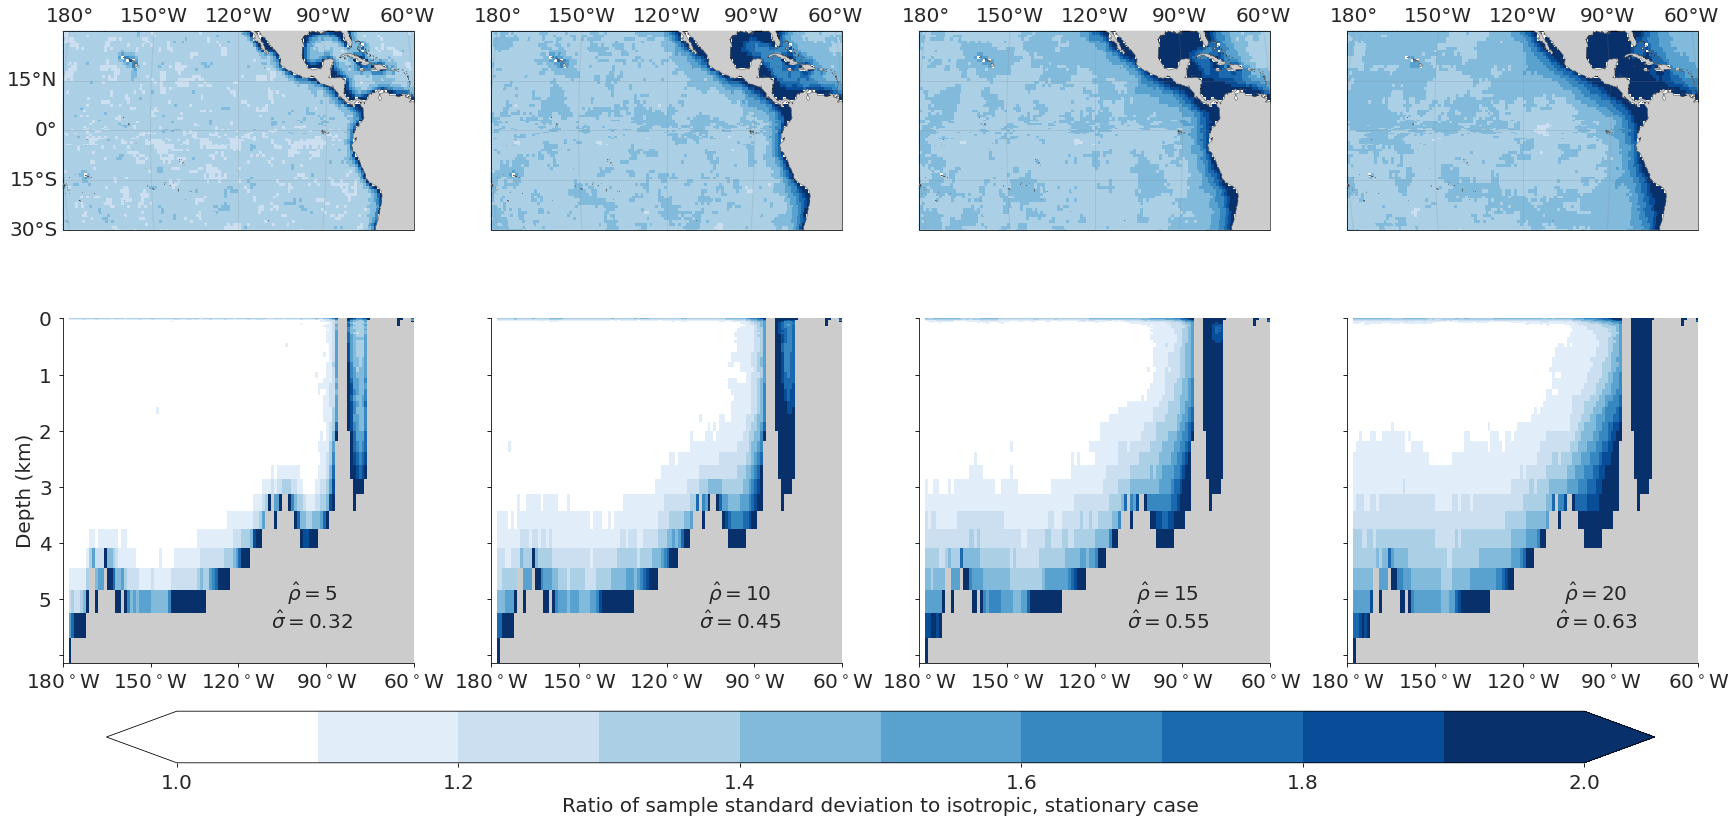

In [70]:
make_normplot('smooth3Dstd001', 'ideal_std', normalize=True, vmin=1, vmax=2, cmap='Blues')
plt.savefig(f"{fig_dir}/std_ratio_{n_applications:02d}apps.jpg", dpi=300, bbox_inches='tight')

### Ratio min/max

- M = 1:
    - norm min/max is ~ 0.1 and 1.1
    - std min/max is ~0.9 and up to 18
    
- M = 2:
    - norm min/max is ~ 0.1 and 1.1
    - std min/max is ~0.9 and up to 25
    
- M = 4:
    - norm min/max is ~ 0.05 and 1.1
    - std min/max is ~0.9 and up to 24
    
- M = 8:
    - norm min/max is ~ 0.05 and 1.1
    - std min/max is ~0.9 and up to 25